In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('events.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors = 'coerce')
#df["storage"] = df["storage"].astype('category')

In [3]:
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour

Ordenamos primero respecto al tiempo y luego con un sort in place ordenamos respecto a las personas.
De esta forma nos quedan todos los logs de una misma persona juntos y ordenados respecto al tiempo

In [4]:
df.sort_values(by=['timestamp']).sort_values(by=['person'], inplace = True)

In [5]:
df['timediff'] = df['timestamp'].diff()
df['timediff'] = df['timediff'].dt.total_seconds()

df['newperson']= df['person'].apply(lambda x: int(x, 16))
df['newperson'] = df['newperson'].diff()
df['newperson'] = (df['newperson'] > 0)

Text(0.5,0,'Diferencia de tiempo en escala logaritmica (2^x segundos)')

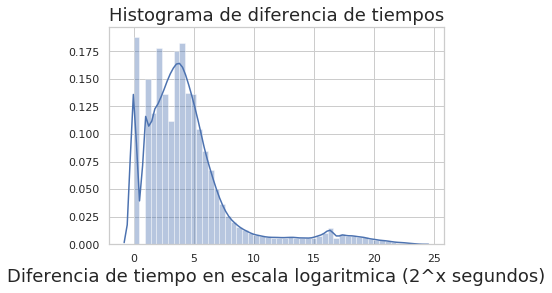

In [6]:
minidf = df.loc[(df['newperson'] == False) & (df['timediff'])]["timediff"]
minidf = np.log2(minidf)
g = sns.distplot(minidf)
g.set_title("Histograma de diferencia de tiempos", fontsize=18)
g.set_xlabel("Diferencia de tiempo en escala logaritmica (2^x segundos)",fontsize=18)


In [7]:
maxtime = 16368

In [8]:
df['viewed_product'] = (df['event'] == 'viewed product')
df['brand_listing'] = (df['event'] == 'brand listing')
df['visited_site'] = (df['event'] == 'visited site')
df['ad_campaign_hit'] = (df['event'] == 'ad campaign hit')
df['generic_listing'] = (df['event'] == 'generic listing')
df['searched_products'] = (df['event'] == 'searched products')
df['search_engine_hit'] = (df['event'] == 'search engine hit')
df['checkout'] = (df['event'] == 'checkout')
df['staticpage'] = (df['event'] == 'staticpage')
df['conversion'] = (df['event'] == 'conversion')
df['lead'] = (df['event'] == 'lead')
df['ad_url_model'] = ((df['url'].str.count('/') == 3) & (df['url'].str.contains('comprar')))
df['ad_url_brand'] = ((df['url'].str.count('/') == 2) & (df['url'].str.contains('comprar')))

In [9]:
df['newentry'] = ((df['timediff'] > maxtime) | (df['newperson']))
df['entry'] = df['newentry'].cumsum()

In [10]:
df['already_buyed'] = (df['conversion'] > 0)
df['already_buyed'] = df.groupby('person')['already_buyed'].cumsum()
df['already_buyed'] = (df['already_buyed'] > 0) & (df['already_buyed'].shift(1) > 0)
df['first_convertion'] = (df['event'] == 'conversion') & (df['already_buyed'] == False)

In [11]:
def primero(serie):
    lista = []
    for i in serie:
        if not pd.isnull(i):
            lista.append(i)
            break
    if lista:
        return lista.pop(0)
    return np.nan

def listar(serie):
    lista = []
    for i in serie:
        if not pd.isnull(i):
            lista.append(i)
    if lista:
        return lista
    return []

dict1 = ({'timestamp':primero, 'person':primero, 'sku':listar, 'model':listar, 'condition':listar,'storage':primero, 'color':listar, 'skus':listar, 
          'search_term':listar, 'staticpage':'sum','campaign_source':primero, 'search_engine':primero, 'channel':primero, 'new_vs_returning':primero,
          'city':primero, 'region':primero, 'country':primero, 'device_type':primero, 'screen_resolution':primero, 'operating_system_version':primero, 
          'browser_version':primero, 'day_of_week':primero, 'month':primero,'hour':primero, 'viewed_product':'sum', 'brand_listing':'sum',
          'visited_site':'sum', 'ad_campaign_hit':'sum', 'generic_listing':'sum','searched_products':'sum', 'search_engine_hit':'sum', 'checkout':'sum', 
          'conversion':'sum','lead':'sum', 'ad_url_model':'sum', 'ad_url_brand':'sum', 'newperson':primero, 'already_buyed':sum, 'first_convertion':sum})

entrydf = df.groupby('entry').agg(dict1)
entrydf['already_buyed'] = (entrydf['already_buyed'] >0)

In [14]:
def calcular_retencion(df):
    if df['conversion'] > 1:
        return 'multiple_conversions'
    
    if df['conversion'] > 0:
        return 'conversion'
    
    if df['checkout'] > 0:
        return 'checkout'
    
    if df['lead'] > 0:
        return 'lead'
    
    if df['searched_products'] > 0:
        return 'searched_products'
    
    if ((df['viewed_product'] > 0) & (df['ad_url_model'] == 0)) | (df['viewed_product'] > 1):
        return 'viewed_product'
    
    if ((df['brand_listing'] > 0) & (df['ad_url_brand'] == 0)) | (df['brand_listing'] > 1):
        return 'brand_listing'
    
    if df['generic_listing'] > 0:
        return 'generic_listing'
    
    if df['search_engine_hit'] > 0:
        return 'search_engine_hit'
    
    if df['visited_site'] > 0:
        return 'visited_site'
    
    return 'ad_campaing_hit' #el default es esto porque por algun motivo algunos logs que solo hacian ad_campaing_hit se quedaban sin esta columna
    
entrydf['retention'] = entrydf.apply(calcular_retencion, axis=1).astype('category')

Text(0,0.5,'Numero de ingresos')

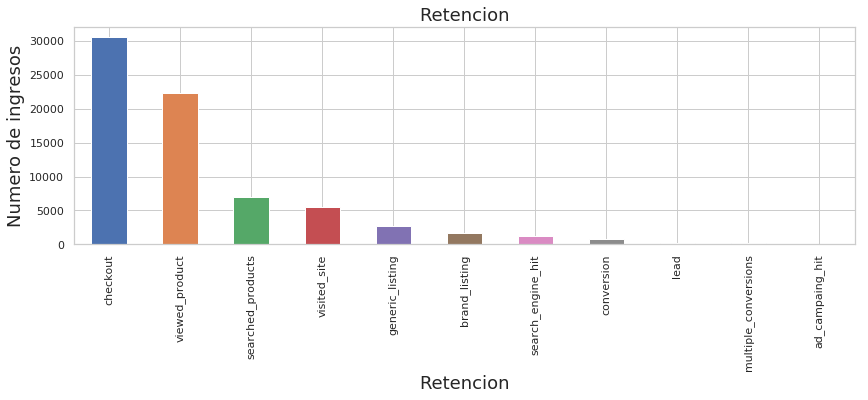

In [34]:
plot = entrydf['retention'].value_counts().plot(kind='bar',figsize=(14,4));
plot.set_title("Retencion", fontsize=18)
plot.set_xlabel("Retencion",fontsize=18)
plot.set_ylabel("Numero de ingresos", fontsize=18)

In [32]:
print(entrydf['campaign_source'].value_counts().head(5))
list = ['google', 'criteo', 'rtbhouse', 'emblue', 'FacebookAds']
cut_entrydf = entrydf.loc[(entrydf['campaign_source'] == 'google') | (entrydf['campaign_source'] == 'criteo') | (entrydf['campaign_source'] == 'rtbhouse') | (entrydf['campaign_source'] == 'emblue') | (entrydf['campaign_source'] == 'FacebookAds')]

google         30930
criteo          6259
rtbhouse        4181
emblue           767
FacebookAds      479
Name: campaign_source, dtype: int64


Text(0,0.5,'Retencion')

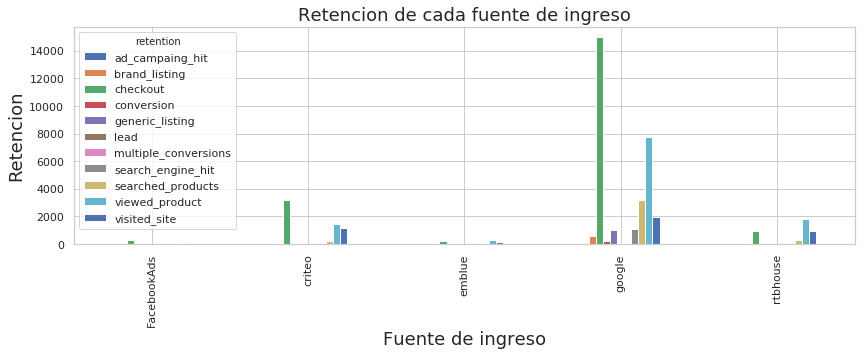

In [33]:
plot=pd.crosstab(cut_entrydf['campaign_source'], cut_entrydf['retention']).plot(kind='bar',figsize=(14,4));
plot.set_title("Retencion de cada fuente de ingreso", fontsize=18)
plot.set_xlabel("Fuente de ingreso",fontsize=18)
plot.set_ylabel("Retencion", fontsize=18)

Text(0,0.5,'Retencion')

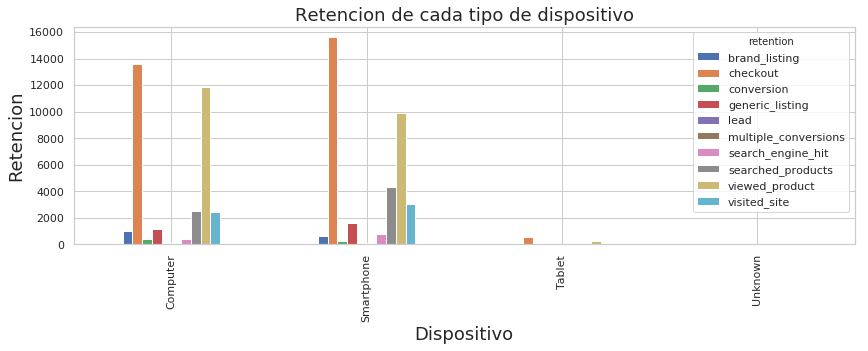

In [19]:
plot=pd.crosstab(entrydf['device_type'], entrydf['retention']).plot(kind='bar',figsize=(14,4));
plot.set_title("Retencion de cada tipo de dispositivo", fontsize=18)
plot.set_xlabel("Dispositivo",fontsize=18)
plot.set_ylabel("Retencion", fontsize=18)

Text(0.5,0,'new vs returning')

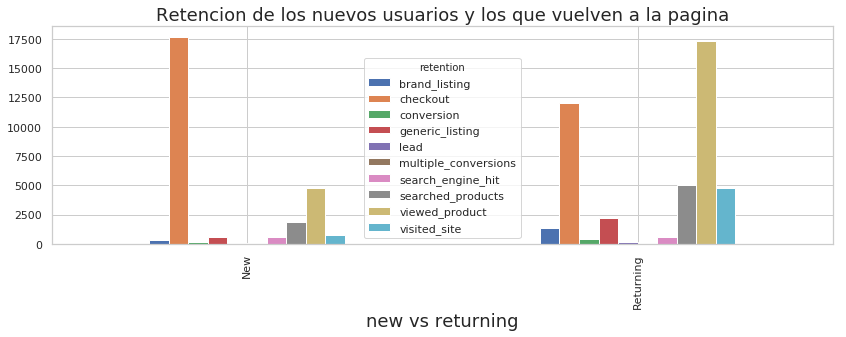

In [20]:
plot=pd.crosstab(entrydf['new_vs_returning'], entrydf['retention']).plot(kind='bar',figsize=(14,4));
plot.set_title("Retencion de los nuevos usuarios y los que vuelven a la pagina", fontsize=18)
plot.set_xlabel("new vs returning",fontsize=18)


Text(0,0.5,'Retencion')

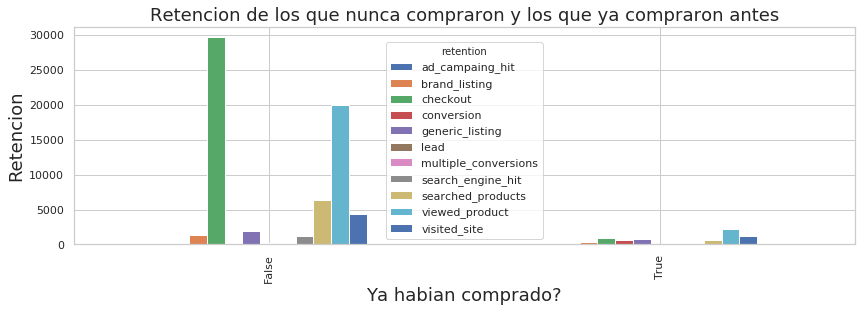

In [21]:
plot=pd.crosstab(entrydf['already_buyed'], entrydf['retention']).plot(kind='bar',figsize=(14,4));
plot.set_title("Retencion de los que nunca compraron y los que ya compraron antes", fontsize=18)
plot.set_xlabel("Ya habian comprado?",fontsize=18)
plot.set_ylabel("Retencion", fontsize=18)